In [1]:
### PREAMBLE
# Classification
# classification.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Linear Classification

Whereas our previous introduction to machine learning focused on the case of predicting real-valued outputs (called the regression setting), these notes consider the case of predicting discrete-valued outputs.  This is called the classification setting.  And while it may seem as though this would require very different techniques to handle (after all, the regression setting we just considered made very "continuous" predictions rather than discrete ones), one nice thing about our generic framework for machine learning is that in reality, there is _very_ little difference between how we handle regression and classification problems.  Like before, there are hypothesis functions, loss functions, and our goal is still to solve the canonical problem of minimizing the sum of losses on a data set (the only real difference is in the choice of loss function, as we will see even the hypothesis class largely remains the same).

## Example: breast cancer classification

As an example to introduce classification problem, we're going to turn to a classical example from the machine learning literature, first presented in [[Street et al, 1993]](http://ftp.cs.wisc.edu/math-prog/tech-reports/olm102.ps) of identifying whether cancer cells from a biospy are malignant or benign.  This was historically an important data set in the intersection of machine learning and health care, and similar subjects are still a topic of very active research.  Of course, 25 years ago, the techniques were much more primitive and computationally less intense than current approaches to similar problems, but the work has become a classical data set in machine learning, and also represent a compelling applications.

To create the data set, researchers took 569 images of cancerous cells, under a microscope, and manually selected the outlines of the different cells (this step is the kind of thing that would ideally be replaced by automatic computer vision architectures in current systems).  The resulting figures looked like this:
![Image of (manually) selected outlines of cells under a microscope.](cancercells.png)
The researchers then considered 10 different features of each cell, of instance the area, perimeter, texture, number of concave points (i.e., indentations), variance of grayscale color, and some others (a full list is in the above paper).  For each of these 10 features they computed the mean, max, and standard deviation of the feature across all the cells in the image, resulting in a 30 dimensional vector describing each sample.

The following is a plot of two of these features (mean # of concave points, and mean area) for all examples in the data set; blue points denotes a benign tumor, whereas red points denote a malignant tumor.  (Note that the dataset is so common, it's included in the actual scikit-learn package itself).

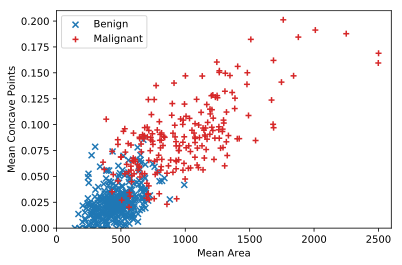

In [11]:
import numpy as np
import sklearn.datasets
dat = sklearn.datasets.load_breast_cancer()

ix = np.where(dat["feature_names"] == "mean area")[0][0]
iy = np.where(dat["feature_names"] == "mean concave points")[0][0]

def plot_cells():    
    plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend(['Benign', 'Malignant'])
plot_cells()

There is obviously some structure to the data here: cells with greater average area and greater numbers of concave points are more likely to be malignant.  And whereas your mental model of simple linear regression should be something like "fitting a line to the data", your mental model of a classification task should be "separating the classes with a line".  Something like the following (just a hand-picked example of a line, we will shortly see how to actually fit these to the data, much like we did for regression).

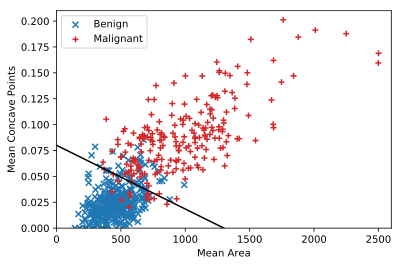

In [3]:
plot_cells()
plt.plot([0, 1300], [0.08,0], 'k-')

Just as our linear regression line did not pass exactly through all the data points, we can't achieve here a line that exactly separates all the data points.  But there is clearly as sense in which points below the line are "more likely" to be benign, and above the line are "more likely" to be malignant.  To make this more formal, we are going to introduce the notation of machine learning classification.

## Classification notation

As a reminder, let's consider the basic elements of a machine learning setup, available in more detail [here](http://www.datasciencecourse.org/notes/ml_intro/#machine-learning-in-general).

- **Inputs (features):** $x^{(i)} \in \mathbb{R}^n, \; i=1,\ldots, m$
- **Outputs:** $y^{(i)} \in \mathcal{Y}, \; i=1,\ldots,m$
- **Parameters:** $\theta \in \mathbb{R}^d$.
- **Hypothesis function:** $h_\theta : \mathbb{R}^n \rightarrow \hat{\mathcal{Y}}$
- **Loss function:** $\ell : \hat{\mathcal{Y}} \times \mathcal{Y} \rightarrow \mathbb{R}_+$
- **Canonical optimization problem:**
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \frac{1}{m}\sum_{i=1}^m \ell(h_\theta(x^{(i)}),y^{(i)})
\end{equation}

In the context of classification, these are mostly unchanged.  The one difference is that the output space, $\mathcal{Y}$, is now a discrete space instead of a continuous one: $\mathcal{Y} = \{-1,+1\}$ for binary classification, or $\mathcal{Y} = \{1,2,\ldots,k\}$ for multiclass classification.  For the remainder of these notes, unless otherwise we're going to assume the binary setting, but it's important to note that our convention will be that $\mathcal{Y} = \{-1,+1\}$ _not_ $\mathcal{Y} = \{0,1\}$ (this will make a difference, since we're going to use the numerical values of $y$ is our loss functions.

The other notable difference is that predicition space (the output of the hypothesis function) $\hat{\mathcal{Y}}$ is actually _still_ the same as it was in the regression setting, $\hat{\mathcal{Y}} = \mathbb{R}$ (again, this assumes binary classification, and we'll make a slight change for the multiclass setting).  This may seem somewhat counter-intuitive: we have outputs in the discrete space $\{-1,+1\}$ and predictions that are real-valued.  Intuitively, the output of our hypothesis function will correspond to some notion of "confidence" in our prediction: the _sign_ of $h_\theta(x)$ determines the most likely output (we are predicting positive if $\mathrm{sign}(h_\theta(x)) = 1$ and negative if $\mathrm{sign}(h_\theta(x)) = -1$), but the magnitude indicates how certain we are: large positive values of $h_\theta(x)$ indicate we are very confident in our positive prediction; very large negative values indicate we are very confident in our negative prediction; and values around zero indicate we are not particularly certain one way or another in our prediction.  Without these notions of confidence, it is extremely difficult to formulate a "smooth" loss that can be optimized with, gradient descent, for example.

The loss functions are the one element that _is_ substantially different between classification and regression, and we will talk about these moment, but first describe how the other elements are instantiated in our cancer classification task.

### Instantiation in cancer domain

In the setting above, predicting benign or malignant cells from the two features shown (here just considering predictions based upon these two features, not all 30 features that are in the dataset), we would set up the problem as:

- **Inputs (features):** $\displaystyle x^{(i)} \in \mathbb{R}^3 = 
\left[\begin{array}{c}\mathrm{MeanArea}^{(i)} \\
\mathrm{MeanConcavePoints}^{(i)} \\ 1 \end{array} \right ]$, where again, we add the constant term 1 to integrate the intercept function directly into the inputs.
- **Outputs:** $y^{(i)} \in \{-1,+1\}$ where $y^{(i)} = -1$ corresponds to a benign tumor and $y^{(i)} = +1$ corresponds to a malignant tumor.  Note that these labels could be switched of course, but for the sake of simplicity we typically try to choose the labels to correspond to our common notions of "positive" and "negative" examples. 
- **Parameters:** $\theta \in \mathbb{R}^3$.  These are the same as before, as we are going to use a linear hypothesis function.
- **Hypothesis function:** We use a linear hypothesis function, $h_\theta : \mathbb{R}^3 \rightarrow \mathbb{R}$, $h_\theta(x) = \theta^T x = \sum_{j=1}^3 \theta_j x_j$.  Again, for classification this will not correspond to a line that goes "through" the data as it did for linear regression, but to a "hyperplane" that is positive in the region where we are predicting positive and negative where we are predictive negative.  The decision boundary, the "line" that _separates_ the data, is given by the equation $h_\theta(x) = 0$.

## Loss functions in classification

How do we define a suitable loss function for classification $\ell : \hat{\mathcal{Y}} \times \mathcal{Y} \rightarrow \mathbb{R}_+$?  This is not completely obvious, because our prediction space is continuous $\hat{\mathcal{Y}} = \mathbb{R}$, while our output space is discrete $\mathcal{Y} = \{-1,+1\}$.  Before defining the loss functions that are actually used in practice in classification, let's consider one "easier" alternative:

### Least squares classification
One of the more obvious approaches we could employ is the following: just use the squared loss (or some regression loss) for our classification task.  In other words, while it is true that the $y^{(i)}$ terms are discrete, we can just treat them as the real-valued numbers $-1$ and $+1$, and use a loss like $\ell(h_\theta(x),y) = (h_\theta(x) - y)^2$.  Despite the fact that I'm about to argue against this approach, it turns out this is not at all a bad idea in practice, and it absolutely makes sense to run this approach (referred to sometimes as "least squares classification") as a first take on classification tasks, especially since we can use the analytic least squares solution.

However, why might this sometimes be a bad idea?  Let's consider the following data set:
![An example one-dimensional classification task.](classification_1.svg)

If we fit a line to this data using least squares, we would get something like the following:
![A least-squarse fit to our one-dimensional problem.](classification_2.svg)

Remember that in the context of classification, we would be predicting a positive class wherever the line is positive, and a negative class where the line is negative.  But this means that we actually predict incorrectly on the left-most positive point: our hypothesis here is negative while the label is positive.  On the other hand, it's of course completely possible to classify the data perfectly with a linear classifier, as in the figure below:
![A perfect (linear) classifier on the one-dimensional problem.](classification_3.svg)

The issue here, of course, is that the least-squares loss function applied to classification aims at predicting _exactly_ $+1$ or $-1$ on each data point.  There is no sense in which it is "ok" to have a number much larger than one for a positive example, whereas of course this is completely acceptable in the classification setting.  And by the nature of the least squares loss (the same is also true even for robust losses, though to a lesser degree), these "outliers" will add greatly to the loss function, and can substantially change the resulting classification of many points.

Motivated by this concern, let's discuss alternative loss functions for classification.

### Zero-one loss

Perhaps the most obvious loss, which is frankly what people just assume to be the "correct" loss for classification problems, is just the number of mistakes that the classifier makes.  That is, if the sign of $h_\theta(x^{(i)})$ is negative while $y^{(i)}$ is positive (or vice versa), this counts as a mistake, whereas the point is correctly classified otherwise.  This is known as the zero-one loss $\ell_{0/1} : \mathbb{R} \times \{-1,+1\} \rightarrow \mathbb{R}_+$, and we can write it as follows
\begin{equation}
\begin{split}
\ell_{0/1}(h_\theta(x), y) & = \left \{ \begin{array}{ll} 0 & \mbox{ if } \mathrm{sign}(h_\theta(x)) = y \\
1 & \mbox{ otherwise } \end{array} \right . \\
& = \mathrm{1}\{h_\theta(x)\cdot y \leq 0\}.
\end{split}
\end{equation}
This last way of writing the quantity is important (here $\mathrm{1}\{\cdot\}$ denotes the zero-one indicator function,  a function that is equal to one if its inner argument is true, and zero otherwise).  Specifically, what is important to consider here is the quantity $h_\theta(x)\cdot y$, the hypothesis times the output.  First, you should convince yourself that the two definitions of the zero-one loss are in fact equivalent: $h_\theta(x)$ and $y$ have the same sign (either positive or negative), then $h_\theta(x)\cdot y$ will be positive, whereas if $h_\theta(x)$ and $y$ have difference signs, then $h_\theta(x)\cdot y$ will be negative, and so incur a loss of one.  But the important notion here is that, with our definition that $h_\theta(x)$ be a measure of how confident we are in our prediction, $h_\theta(x)\cdot y$ will be positive if we are "confidently correct" and very negative if we are "confidently incorrect" (we have a prediction with large magnitude, but which is incorrect).

Let's consider a plot of the zero-one loss below.

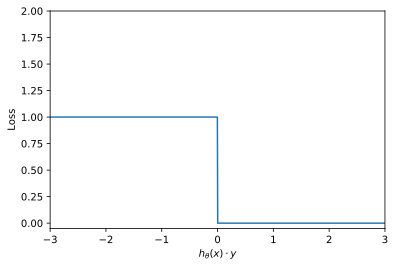

In [4]:
hy = np.linspace(-3,3,1000)
plt.plot(hy,(hy<=0))
plt.xlim([-3,3])
plt.ylim([-0.05, 2])
plt.ylabel("Loss")
plt.xlabel("$h_θ(x) \cdot y$")

Note that the $x$ access here is precisely the quantity we discussed $h_\theta(x)\cdot y$, whereas the $y$ axis shows the loss we suffer.  This is the common way of visualization (binary) classification losses, as it shows how much loss is suffered as the prediction gets more confidently correct or incorrect (of course, for zero-one loss there is no notion of confidence).

While zero-one loss is very natural to consider for classification problems, it has two main challenges: first, it is difficult to optimize.  We won't show it here, but it turns out that in general it is NP-hard to find even a linear classifier that minimizes the zero-one loss for a general collection of points.  The second issue is that the zero-one loss is non-smooth, and has derivative equal to zero everywhere except for the zero point, where the derivative is undefined.  This makes it very difficult to even _approximately_ minimize the total zero-one loss (with techniques like gradient descent).  Thus, we typically want to consider alternative loss functions for classification tasks.

### Alternative losses for classification

Given the difficulties of minimizing sum of zero-one losses, one typically uses an alternative loss in classification.  There are many such losses, and different choices here lead to different machine learning algorithms (often with very little indication that all that differs between the algorithm is in fact the choice of loss function).  Let's consider a few of of the more common ones:

- **Logistic loss:** $\ell_{\mathrm{logistic}}(h_\theta(x), y) = \log(1+\exp(-h_\theta(x) \cdot y))$  <br/> For large positive values of $h_\theta(x) \cdot y$, $\exp(-h_\theta(x) \cdot y)$ will be very close to zero, so the loss will approach zero; for large negative values $\log(1+\exp(-h_\theta(x) \cdot y)) \approx -h_\theta(x) \cdot y$ so the loss increases approximately linearly.
- **Hinge loss:** $\ell_{\mathrm{hinge}}(h_\theta(x), y) = \max\{1 - h_\theta(x) \cdot y, 0\}$ <br/>  As long as $h_\theta(x) \cdot y \geq 1$, this loss will be zero, whereas it will increase linearly for negative $h_\theta(x) \cdot y \geq 1$.
- **Exponential loss:** $\ell_{\mathrm{exp}}(h_\theta(x), y) = \exp(-h_\theta(x) \cdot y)$ <br/> For a similar reason as with logistic loss, this loss will go to zero for large $h_\theta(x) \cdot y$; but for negative $h_\theta(x) \cdot y$ the loss increases very quickly.

Let's plot some of these loss functions relative to zero-one loss.

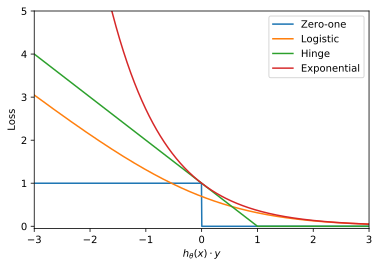

In [5]:
hy = np.linspace(-3,3,1000)
plt.plot(hy,(hy<=0))
plt.plot(hy, np.log(1+np.exp(-hy)))
plt.plot(hy, np.maximum(1 - hy, 0))
plt.plot(hy, np.exp(-hy))
plt.xlim([-3,3])
plt.ylim([-0.05, 5])
plt.ylabel("Loss")
plt.xlabel("$h_θ(x) \cdot y$")
plt.legend(['Zero-one', 'Logistic', 'Hinge', 'Exponential'])

One thing that notably differs between these losses is the scale to which they are affected by outliers (in the classification context, meaning points that have high magnitude hypothesis, but which are classified incorrectly, i.e., the "confidently incorrect" points).  Zero-one loss is the least sensitive to such outliers, as it suffers the same loss regardless of how confident the incorrect prediction is.  Exponential loss is on the other extreme, with a loss function that increases extremely quickly for predictions that confidently incorrect.  And logistic and hinge loss lie somewhere in between, with a loss that increases _linearly_ with the confidence of incorrect predictions.  In fact, logistic loss and hinge loss are extremely similar in this regard, with the primary difference being that the logistic loss is continuously differentiable and always strictly positive, whereas the hinge loss has a non-differentiable point at one, and is exactly zero beyond this point.

### Solving classification tasks

With this framework and set of loss functions laid out, the task of learning a classifier is exactly the same as the regression methods we considered previously.  That is, given a data set we seek to minimize the average loss
\begin{equation}
\minimize_\theta \frac{1}{m}\sum_{i=1}^m \ell(h_\theta(x^{(i)}),y^{(i)}).
\end{equation}

Unlike regression, there is virtually no setting (except, of course, just using least-squares loss) where there is an analytical solution to this optimization problem.  Nonetheless, we can still solve it by resorting back to gradient descent (there are alternative optimization approaches for most of these problems, but we'll only cover gradient descent).  To see how this works, we'll next consider some collection of specific machine learning algorithms that result in specific choices of loss function.

## Example classification algorithms

Let's consider a few specific cases of machine learning algorithms, which really just result from different choices of loss functions.  In all cases, we'll simply present the loss and derive the gradient, then illustrating how to perform the gradient descent algorithm.

### Support vector machines

Support vector machines (SVMs) result from choosing hinge loss
\begin{equation}
\ell_{\mathrm{hinge}}(h_\theta(x),y) = \max \{1-h_\theta(x)\cdot y, 0\}
\end{equation}
as the loss function to minimize.  If you have seen support vector machines before, you may have seen them explained in a geometric context, illustrating that they maximize the "margin" of separation between examples of different classes.  This is true, and support vector machines absolutely can be viewed this way.  But it is also instructive to simply understand them as minimizing the particular loss function above.

Support vector machines also refer either to a linear hypothesis function, or a particular form of nonlinear hypothesis known as a _kernel_ hypothesis; if you ever hear the terms "linear SVM" or "kernel SVM", this is just the designation of which type of hypothesis function they are using.  That is, linear SVMs use the hypothesis function
\begin{equation}
h_\theta(x) = \sum_{j=1}^n \theta_j x_j = \theta^T x,
\end{equation}
exactly as we have seen before in the linear regression case.  While we won't discuss it in any detail here (and we will only briefly discuss it when we talk about nonlinear hypotheses next lecture), very briefly, a kernel SVM uses the hypothesis function
\begin{equation}
h_\theta(x) = \sum_{i=1}^m \theta_i K(x,x^{(i)})
\end{equation}
where $\theta \in \mathbb{R}^m$ are the parameters, and $K : \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R}$ is known as a _kernel function_.  The interesting elements to note here are the fact that $\theta$ now is the same size as the _number of data points_ (that is, it is $m$ dimension, this is not a typo), and the prediction on some new point $x$ requires evaluating the kernel function $K(x, x^{(i)})$ between the input to our hypothesis $x$ and all our data points.  This means that the complexity kernel approaches will scale with the number of datapoints instead of the dimension of the input.  Again, we aren't describing this here in any detail, but you should be aware of some of these big ideas.  For now, we will only consider the case of the linear SVM, so we're going to assume a linear hypothesis for the remainder of this section.

In addition to the hinge loss term above, A little bit more correctly, support vector machines actually include another term besides just the average loss in their formulation: a _regularization_ term that penalizes the (squared) magnitude of the sum of weights $\sum_{j=1}^n\theta^2_j$.  We're going to cover regularization much more next lecture, so we won't address this point any more for now, except to say that it has the effect of balancing out the "complexity" of the classifier (which increases with larger weights) with the goal of minimizing the loss.  With this additional term, the full optimization problem considered by a (linear) support vector machine is given by
\begin{equation}
\minimize_{\theta} \frac{1}{m} \sum_{i=1}^m \max \{1-\theta^T x^{(i)} \cdot y^{(i)}, 0\} + \lambda \sum_{j=1}^n \theta_j^2
\end{equation}
where $\lambda \in \mathbb{R}_+$ is what is called a _regularization parameter_ that trades off between the goal of minimizing the loss and keeping the weights small.

Let's derive the gradient descent algorithm for linear SVMs.  Recall that the hinge loss looks like the following, as a function of $h_\theta(x) \cdot y$:

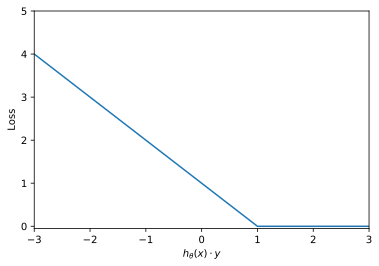

In [6]:
hy = np.linspace(-3,3,1000)
plt.plot(hy, np.maximum(1 - hy, 0))
plt.xlim([-3,3])
plt.ylim([-0.05, 5])
plt.ylabel("Loss")
plt.xlabel("$h_θ(x) \cdot y$")

Thus, the partial derivative of the loss is given by
\begin{equation}
\frac{\partial}{\partial \theta_j} \max \{1-\theta^T x \cdot y, 0\} = -x_j y 1\{\theta^T x \cdot y \leq 1\},
\end{equation}
the gradient of the regularization term is given by
\begin{equation}
\frac{\partial}{\partial \theta_j}\lambda \sum_{k=1}^n \theta_k^2 = 2\lambda \theta_j
\end{equation}
and so the gradient of the entire objective is given by
\begin{equation}
\begin{split}
\nabla_\theta E(\theta) & = 
\nabla_\theta \left (\frac{1}{m} \sum_{i=1}^m \max \{1-\theta^T x^{(i)} \cdot y^{(i)}, 0\} +\lambda \sum_{k=1}^n \theta_k^2\right ) \\ &
= \frac{1}{m} \sum_{i=1}^m -x^{(i)} y^{(i)} 1\{\theta^T x^{(i)} \cdot y^{(i)} \leq 1\} + 2\lambda \theta.
\end{split}
\end{equation}

We can write this efficiently in matrix format (using the same matrix definitions as we used in the previous lecture), as 
\begin{equation}
\nabla_\theta E(\theta) = -\frac{1}{m}X^T Y 1\{Y X\theta \leq 1\} + 2 \lambda \theta
\end{equation}
and where $Y = \mathrm{diag}(y)$ is a diagonal matrix made from the elements of $y$ (not that you wouldn't actually from this matrix, this just scales the rows of $X$ by $y$.  Here is what this looks like in code.

In [8]:
def svm_gd(X, y, alpha, iters, lam):
    m,n = X.shape
    theta = np.zeros(n)
    YX = X * y[:,None]
    loss, err = np.zeros(iters), np.zeros(iters)
    for t in range(iters):
        hy = YX @ theta
        loss[t] = np.maximum(1-hy,0).mean()
        err[t] = (hy <= 0).mean()
        theta -= alpha * (-YX.T @ (YX @ theta <= 1)/m + 2*lam*theta)
    return theta, loss, err

Again, the actual nuts and bolts of a complex seeming ML algorithm boils down to something fairly simple.  Let's apply this to our example above, where we now go through the normal routine of normalizing the data, etc (note that for a  classification tasks, we naturally don't normalize the output).

In [53]:
def normalize_data(X, normalize_cols):
    """ Normalize specified columns of X to range [0,1] in place. """
    min_X = X[:,normalize_cols].min(axis=0)
    max_X = X[:,normalize_cols].max(axis=0)
    X[:,normalize_cols] = (X[:,normalize_cols] - min_X) / (max_X - min_X)
    return min_X, max_X

def unnormalize_theta(theta, normalize_cols, ranges):
    theta[normalize_cols] /= (ranges[1] - ranges[0])
    theta[-1] -= theta[normalize_cols] @ ranges[0]
    return theta

The following code will now create the $X$ and $y$ matrices and vectors, normalize the data, run gradient descent for the SVM (for 1000 iterations, with regularization $\lambda = 0.001$, and with step size $\alpha = 1$), and then unnormalize the resulting $\theta$ vector to get its representation back in the original (unnormalized) coordinates.

In [113]:
# build the data and run the SVM
X0 = np.asarray([dat["data"][:,ix], dat["data"][:,iy], np.ones(dat["data"].shape[0])]).T
y0 = (1.*(dat["target"]==np.where(dat["target_names"] == "malignant")[0][0]) +
     -1.*(dat["target"]==np.where(dat["target_names"] == "benign")[0][0]))

X, y = X0.copy(), y0.copy()
ranges = normalize_data(X, [True, True, False])
theta, loss, err = svm_gd(X,y, 1.0, 1000, 1e-3)
unnormalize_theta(theta, [True, True, False], ranges)
print(theta)

[  1.67393642e-03   2.95613635e+01  -2.80709431e+00]


Let's first visualize what this classification looks like.  Note that here we are using the `contour` functions to draw the positive and negative regions; for a simple linear classifier there are easier ways, but the approach here will also work for nonlinear classifiers with appropriate modifications.

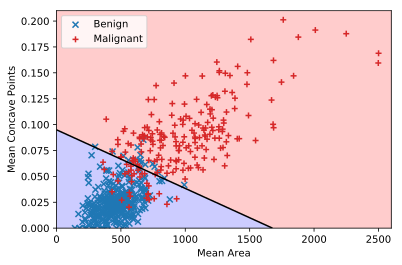

In [107]:
def plot_classification(theta):
    x_range = [0,2600]
    y_range = [0, 0.21]

    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy), np.ones(xx.size)]).T
    zz = (X_ @ theta).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-100.0,0,100.0],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    s2 = plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2], ['Benign', 'Malignant'])
plot_classification(theta)

We can also look the evolution of this classifier over time.  Here is the classifier after 10 iterations of gradient descent (recall that the number of iterations is the third argument to the gradient descent algorithm).

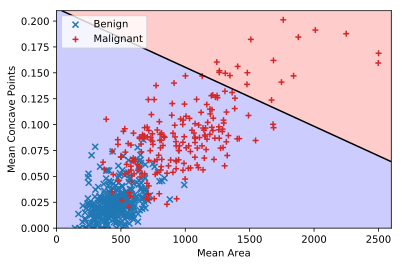

In [42]:
plot_classification(unnormalize_theta(svm_gd(X,y, 1.0, 10, 1e-3)[0], [True, True, False], ranges))

Now 50 iterations.

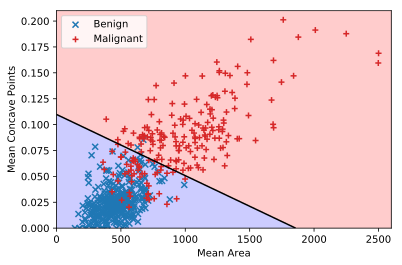

In [43]:
plot_classification(unnormalize_theta(svm_gd(X,y, 1.0, 50, 1e-3)[0], [True, True, False], ranges))

And 100 iterations.

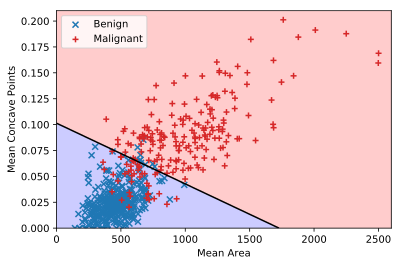

In [44]:
plot_classification(unnormalize_theta(svm_gd(X,y, 1.0, 100, 1e-3)[0], [True, True, False], ranges))

At this point we've mostly converged to the separating hyperplane, though you can inspect things visually to see that the the boundary does change slightly after 1000 iterations.

We can also look at the progress of the error and loss over these iterations.  Note that by how we are defining the error, it will always be 100% after the first iteration, so we only plot it for later iterates.

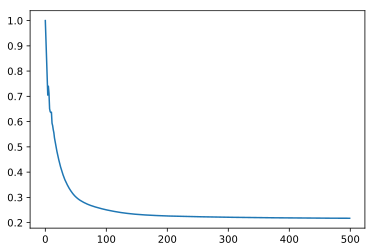

In [51]:
theta, loss, err = svm_gd(X,y, 1.0, 500, 1e-3)
plt.plot(loss)

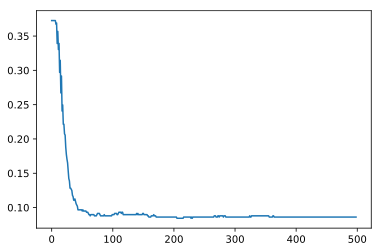

In [52]:
plt.plot(err[1:]) # err[0] is always 1.0, so we only look at 

There are a few points worth emphasizing here.  One point to notice is that while the loss decreases fairly smoothly over the iterations (there are some slight increases in early iterations, but by the end the decrease is quite stable), the error is much less smooth.  Further, while the loss continues to crease through much of the training, the error itself reaches its minimum level fairly quickly, then remains more or less at the same level, both increasing and decreasing over time.  This is not that unexpected: because we are minimizing hinge loss, which is only an approximation to the underlying error, we don't expect the error to decrease monotonically throughout the training process.

### Aside: Alternative normalization

At this point, it is also worth emphasizing some alternative methods methods for normalizing the data, and see what effect they have on the performance.  Thus far, we have been normalizing all columns of the data (except for the constant feature), to lie in the range $[0,1]$.  Just to highlight two common alternatives, we could normalize features to lie in the range $[-1,1]$ or normalize them to have zero mean and unit variance.  Let's look at the resulting behavior of the classifier for these two alternatives.   We're not going to derive all the formulas for unnormalizing $\theta$ here, but they proceed in exactly the same manner as in the previous set of notes.

In [88]:
def normalize_data_2(X, normalize_cols):
    """ Normalize specified columns of X to range [-1,1] in place. """
    min_X = X[:,normalize_cols].min(axis=0)
    max_X = X[:,normalize_cols].max(axis=0)
    X[:,normalize_cols] = 2*(X[:,normalize_cols] - min_X) / (max_X - min_X) - 1
    return min_X, max_X

def unnormalize_theta_2(theta, normalize_cols, ranges):
    """ Unnormalize theta from [-1,1] feature normalization"""
    theta[-1] -= theta[normalize_cols].sum()
    theta[normalize_cols] *= 2/(ranges[1] - ranges[0])
    theta[-1] -= theta[normalize_cols] @ ranges[0]
    
    
def normalize_data_3(X, normalize_cols):
    """ Normalize specified columns of X to have zero mean and unit variance"""
    mean_X = X[:,normalize_cols].mean(axis=0)
    std_X = X[:,normalize_cols].std(axis=0)
    X[:,normalize_cols] = (X[:,normalize_cols] - mean_X)/std_X
    return mean_X, std_X

def unnormalize_theta_3(theta, normalize_cols, mean_std):
    """ Unnormalize theta from zero mean unit variance feature normalization"""
    theta[normalize_cols] /= mean_std[1]
    theta[-1] -= theta[normalize_cols] @ mean_std[0]


Let's first look at what happens when we apply $[-1,1]$ feature normalization.

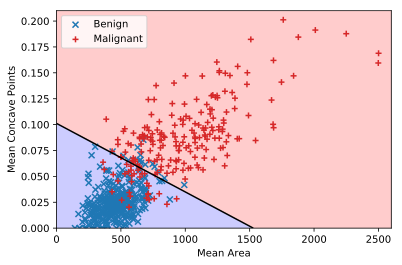

In [91]:
# build the data and run the SVM
X, y = X0.copy(), y0.copy()
ranges = normalize_data_2(X, [True, True, False])
theta, loss, err = svm_gd(X,y, 1.0, 500, 1e-3)
unnormalize_theta_2(theta, [True, True, False], ranges)
plot_classification(theta)

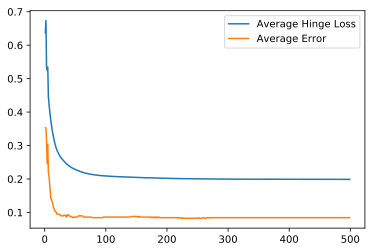

In [92]:
plt.plot(range(1,500),loss[1:], range(1,500), err[1:])
plt.legend(["Average Hinge Loss", "Average Error"])

And let's also look at zero mean and unit variance normalization.

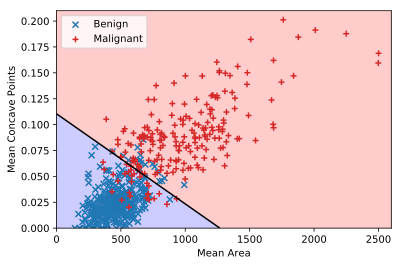

In [298]:
# build the data and run the SVM
X, y = X0.copy(), y0.copy()
mean_std = normalize_data_3(X, [True, True, False])
theta, loss, err = svm_gd(X,y, 1.0, 500, 1e-3)
unnormalize_theta_3(theta, [True, True, False], mean_std)
plot_classification(theta)

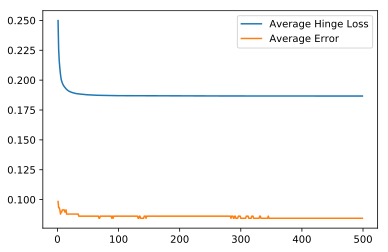

In [103]:
plt.plot(range(1,500),loss[1:], range(1,500), err[1:])
plt.legend(["Average Hinge Loss", "Average Error"])

This last version (normalizing features to have zero mean and unit variance) looks much better in this case.  Indeed, after just one gradient descent step, our classifier already has less than 10% error.  And while the best normalization method is ultimately data-dependent, this strategy (normalizing columns to have zero mean and unit variance), is indeed the most common strategy used in practice, and should likely be the default strategy you attempt when needing to normalize features.

### Logistic regression

Logistic regression results from choosing the logistic loss
\begin{equation}
\ell_{\mathrm{logistic}}(h_\theta(x), y) = \log(1+\exp(-h_\theta(x) \cdot y))
\end{equation}
as our classification loss to minimize.  Logistic regression also has a nice probabilistic interpretation: certain quantities give the _probability_, under a particular model, of an example being positive or negative. We will consider this probabilistic setting more in a later lecture, but for now we are going to simply treat it an another loss minimization algorithm.

Assuming a linear hypothesis function (the typical assumption under logistic regression), the partial deriative of the logistic loss is given by
\begin{equation}
\begin{split}
\frac{\partial}{\partial \theta_j} \log(1+\exp(-\theta^T x \cdot y)) & = \frac{1}{1+\exp(-\theta^T x \cdot y)} \frac{\partial}{\partial \theta_j} (1+\exp(-\theta^T x \cdot y))\\  
& = - \frac{\exp(-\theta^T x \cdot y)}{1+\exp(-\theta^T x \cdot y)} x_j\cdot y \\
& = -\frac{1}{1+\exp(\theta^T x \cdot y)} x_j\cdot y
\end{split}
\end{equation}
where in the last line we use the fact that
\begin{equation}
\frac{\exp(-x)}{1+\exp(-x)} = \frac{\exp(-x)}{1+\exp(-x)} \cdot \frac{\exp(x)}{\exp(x)} = \frac{1}{1+\exp(x)}
\end{equation}


Thus, the gradient of the entire objective function for logistic regression (we'll omit any regularization term, though we could also add this if desired) is given by

\begin{equation}
\begin{split}
\nabla_\theta E(\theta) & = 
\nabla_\theta \frac{1}{m} \sum_{i=1}^m \log \left (1+ \exp \left (\theta^T x^{(i)} \cdot y^{(i)} \right )\right) \\
& = \frac{1}{m} \sum_{i=1}^m -x^{(i)} y^{(i)} \frac{1}{1+\exp\left(\theta^T x^{(i)} \cdot y^{(i)}\right)}.
\end{split}
\end{equation}

We can use this derivation to write the gradient descent procedure for logistic regression, which differs in only two lines (the loss and gradient computation) from the support vector machine implementation.

In [110]:
def logistic_reg_gd(X, y, alpha, iters):
    m,n = X.shape
    theta = np.zeros(n)
    YX = X * y[:,None]
    loss, err = np.zeros(iters), np.zeros(iters)
    for t in range(iters):
        hy = YX @ theta
        loss[t] = np.log(1+np.exp(-hy)).mean()
        err[t] = (hy <= 0).mean()
        theta -= alpha * -YX.T @ (1/(1+np.exp(YX @ theta)))/m
    return theta, loss, err

Let's run logistic regression for the case where we normalize the features to have zero mean and unit variance.

In [129]:
X, y = X0.copy(), y0.copy()
mean_std = normalize_data_3(X, [True, True, False])
theta, loss, err = logistic_reg_gd(X,y, 1.0, 500)
unnormalize_theta_3(theta, [True, True, False], mean_std)
print(theta)

[  7.53314260e-03   8.39815289e+01  -9.35777233e+00]


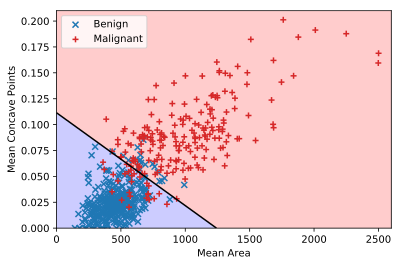

In [130]:
plot_classification(theta)

Let's also look at the evolution of the loss and error for this algorithm.

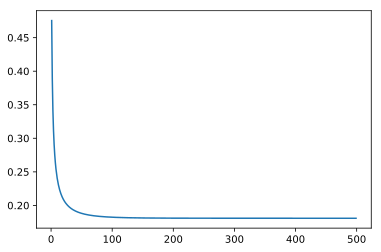

In [123]:
plt.plot(range(1,500),loss[1:])

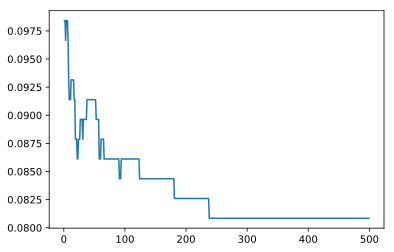

In [124]:
plt.plot(range(1,500),err[1:])

The main point to emphasize here is that despite the fact that support vector machines and logistic regression are often framed in very different ways, both the formulations and results are quite similar here.  The only difference between the two algorithms comes from their loss functions, and the hinge loss and logistic loss share similar properties in terms of the overall nature of the loss: they both approach zero for $h_\theta(x) \cdot y$ large positive (hinge loss actually attains the zero value), and they both are approximately linear for $h_\theta(x) \cdot y$ large negative.  Not surprisingly, then, they both result in very similar (though not exactly identical) separating hyperplanes for this particular problem.

## Multiclass classification

Before we move on to discuss Python libraries for classification, we'll briefly mention how to extend the setting we have considered so far, which has focused on binary classification, to the case of multi-class classification (when the output has multiple discrete values, ${1,\ldots,k}$).  Generally speaking, there are two ways to deal with multiclass classification, either by reduction to binary classification, or with loss functions designed specifically for the multiclass case.  The presentation here will be very brief, so do not worry if this seems a bit unclear; it is not required for what we will discuss next, but may be helpful if you are thinking about how multiclass settings are handled internally by classifiers.

To make this concrete, in our original machine learning problem setup, multiclass classification corresponds to the setting where the output space is some discrete set.
\begin{equation}
\mathcal{Y} = \{1,\dots,k\}
\end{equation}

### Multiclass clasification via binary classification

One of the simplest methods for dealing with multiclass problems is the so-called _one versus all_ method.  In this method, we replace the one multiclass classification problem with $k$ different binary classification problems, where the $i$th binary classification problem asks "is the class $i$ or not $i$".  That is, we create $k$ different binary classifier hypothesis functions
\begin{equation}
h_{\theta_i} : \mathbb{R}^n \rightarrow \mathbb{R}
\end{equation}
where we train parameters $\theta_i$ on the binary classification problem of whether or not the output is class $i$ (i.e., the label is $+1$ if the class is $i$, and $-1$ otherwise).

Given a new example, we now can query each of the $k$ classifier to predict the class.  The trouble here is that more than one classifier might return a positive prediction (meaning that it is "predicting" the class to be more than one of the multiclass values); or no prediction might be positive, indicating that it is none of the classes.  Fortunately, because each hypothesis function predicts a real-valued output corresponding to the "confindence" in each prediction, we have a natural way to make our final predictions.  That is, we simply output the hypothesis with the greatest degree of confidence (even if it is below zero)
\begin{equation}
\DeclareMathOperator*{\argmax}{argmax}
y_{\mathrm{pred}} = \argmax_{i \in \{1\ldots,k\}} h_{\theta_i}(x)
\end{equation}

### "Native" multiclass classification

One way to interpret the approach about is that we are actually defining the hypothesis function for a multiclass classifier not as the function $h_\theta : \mathbb{R}^n \rightarrow \mathbb{R}$ mapping inputs to real-valued predictions, but as a function $h_\theta : \mathbb{R}^n \rightarrow \mathbb{R}^k$ mapping inputs to $k$-dimensional predictions, one for each class label; that is, the prediction space for a multiclass problem is simply $\hat{\mathcal{Y}} = \mathbb{R}^k$.    These predictions are similar to the binary classification case in that they are not predictions directly in the output class, but rather the term $h_\theta(x)_i$ (the $i$th term of this $k$-dimensional output) is a real-valued indicator of the relative "confidence" we have that the label is $i$.

Further, while we can certainly train these confidence levels each with its own binary classification task, it is also possible to define a "native" loss function specifically for these multivariate outputs.  That is, this is a loss function $\ell : \mathbb{R}^k \times \{1,\ldots,k\} \rightarrow \mathbb{R}_+$ that takes a prediction in $\mathbb{R}^k$, a true label in $\{1,\ldots,k\}$, and computes some loss.  It turns out that there are natural analogues of most binary losses (e.g., hinge, logistic), in this multiclass setting.  One of the most common is known at the softmax loss (also called cross entropy loss), which is given by
\begin{equation}
\ell(h_\theta(x), y) = \log \sum_{i=1}^k \exp\left(h_\theta(x)_i \right) - h_\theta(x)_y
\end{equation}
and which is in some sense the natural analogue of the logistic loss (this is not easy to see at first, but you can start to see this by considering the case of a "multiclass" setting with two classes, and noting that this actually reduces to the logistic loss).

This second approach is indeed the slightly more common way to handle the multiclass classification setting, as it requires us to build only one classifier instead of multiple classifiers, and so is typically slightly more efficient.  However, again we emphasize that this is just a brief presentation of the approach, and we won't discuss it here in more detail.


## Classification with scikit-learn

The scikit-learn library, which we previously discussed in the context of linear regression, also has built-in algorithms for classification.  Using these again just requires the initialization, `.fit()`, and `.predict()` methods, with the additional note that if you want the actual output of the hypothesis function, you need to use the `.decision_function()` call.

We also consider here the scikit-learn way ofp normalizing features.  This is done via the `sklearn.preprocessing.StandardScalar` class.  These have a similar interface as the machine learning classes, with a similar method `.fit()` (which computes the mean and variance of a column), and `.transform()` (which converts the data to have zero mean and unit variance).  Let's see how this class works.

In [305]:
from sklearn.preprocessing import StandardScaler

X,y = X0.copy()[:,:-1], y0.copy() # scikit learn doesn't require additional all-ones columns
print(np.mean(X,axis=0), np.std(X,axis=0))
norm = StandardScaler()
norm.fit(X)
print(np.mean(norm.transform(X),axis=0), np.std(norm.transform(X),axis=0))

[  6.54889104e+02   4.89191459e-02] [  3.51604754e+02   3.87687325e-02]
[ -8.79983452e-16   9.73249991e-16] [ 1.  1.]


You can also simultaneously fit and transform using the `.fit_transform()` function.

Let's see how to fit a linear SVM to this (transformed) data.  We'll use the `sklearn.svm.SVC` (for support vector classifier) class to do this.

In [306]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C = 1/(2*1e-3*X.shape[0]))
model.fit(norm.fit_transform(X), y)

SVC(C=0.8787346221441124, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We can compute the error of this classifier by looking at the number of predictions that match the true class in the data set.

In [307]:
(model.predict(norm.transform(X)) != y).mean()

0.086115992970123026

We can also visualize the classifier using the same basic method as before.  Note that instead of transforming the classifier to work in the "original" space, here we just transform any data according to the normalization class before we pass it to the fit model.

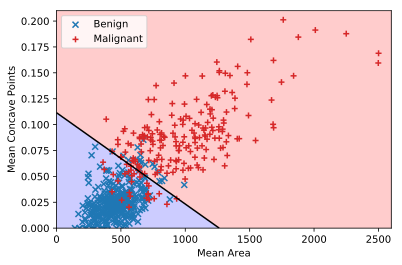

In [310]:
def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]

    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    s2 = plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2], ['Benign', 'Malignant'])
plot_classification_sklearn(model, norm)

This naturally looks virtually identical to the SVM that we trained (specifically when using zero mean and unit variance normalization).  However, there are a few notable differences between the scikit-learn SVM and the one we defined here.  First, whereas we defined the objective function to minimize as
\begin{equation}
E(\theta) = \frac{1}{m}\sum_{i=1}^m \ell_{\mathrm{hinge}}(\theta^T x^{(i)},y^{(i)}) + \lambda \|\theta\|_2^2
\end{equation}
scikit learn define it as
\begin{equation}
E(\theta) = C \sum_{i=1}^m \ell_{\mathrm{hinge}}(\theta^T x^{(i)},y^{(i)}) + \frac{1}{2} \|\theta\|_2^2.
\end{equation}
In other words, the $C$ parameter acts as an inverse of the $\lambda$ parameter we have discussed, and we should select $C = 2/(m\lambda)$ if we want to convert between the two cases.  And while you don't need to typically remember this formula (the $\lambda$ parameter has no inherent meaning, and we typically need to do some form of search over it anyway), you _do_ need to remember that larger $C$ corresponds to _less_ regularization, whereas larger $\lambda$ corresponds to _more_ regularization.

The other (more minor) distinction is that the `SVC` class doesn't apply regularization to the constant-feature term (which would be $\theta_3$ in this example).  This results from a small difference in how the "geometric" versus "loss-based" SVMs are usually formulated, but doesn't make too much of a difference in practice.

There is also a `LinearSVC` class which uses a slightly different algorithm, but which is largely similar.  Note that this class by default uses the squared hinge loss rather than the hinge, so we need to specify `loss='hinge'` if we want the normal hinge. 

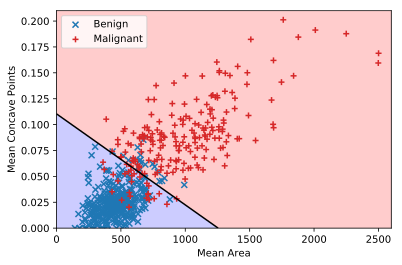

In [302]:
model = LinearSVC(loss='hinge', C = 2/(1e-3*X.shape[0]))
model.fit(trans.fit_transform(X), y)
plot_classification_sklearn(model, norm)

Finally, we also highlight the `LogisticRegression` class.  This class also uses the $C$ parameterization for regularization instead of the $\lambda$ parameterization, so if we want to simulate something like we did above (we used no regularization), we can choose a very large $C$ term.

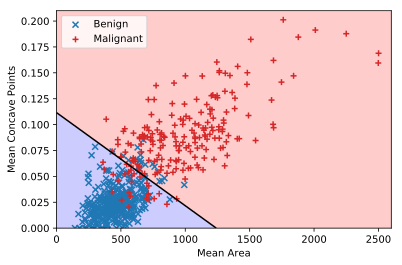

In [304]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e5)
model.fit(trans.fit_transform(X), y)
plot_classification_sklearn(model, trans)

The obvious benefit of the scikit-learn over the custom methods is that we don't need to implement the manual gradient descent, or perform the normalization manually.  And in practice, you typically _will_ just use the libraries, though again it's useful to understand what they are doing behind the scenes to have some sense of when algorithms will or will not work as you hope.